In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [7]:
lsbg_cat = Table.read('./Catalog/COSMOS/cosmos_cutout_cat_COSMOS.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [10]:
meas_cat = Table.read('./Catalog/COSMOS/_lsbg_measure_vanilla.fits')

In [11]:
len(meas_cat[(~np.isnan(meas_cat['ID']))])

373

### Analysis

In [12]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [13]:
meas_cat = Table.read('./Catalog/COSMOS/_lsbg_measure_vanilla.fits')

In [14]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [15]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [16]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 48
Gal: 135
Junk: 190


In [17]:
#lsbg_cat[candy & mask]

(-0.5, 2.2)

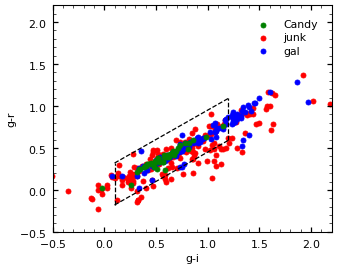

In [18]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2.2)
plt.ylim(-0.5, 2.2)

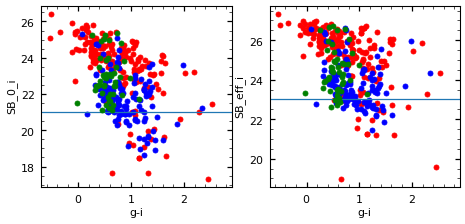

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(axes[0])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_0_i')
plt.axhline(21.)
plt.xlim(-0.7, 2.9)

plt.sca(axes[1])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_eff_i')
plt.axhline(23.)
plt.xlim(-0.7, 2.9)

plt.subplots_adjust(wspace=0.2)

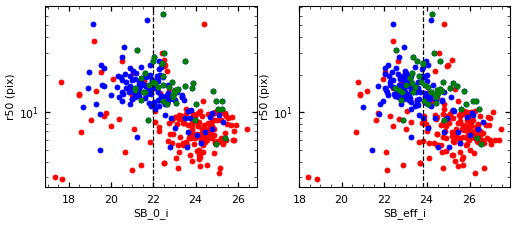

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax1)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50 (pix)')

plt.sca(ax2)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50 (pix)')


plt.subplots_adjust(wspace=0.2)

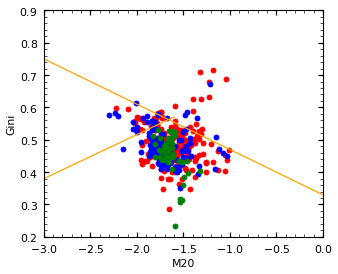

In [21]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

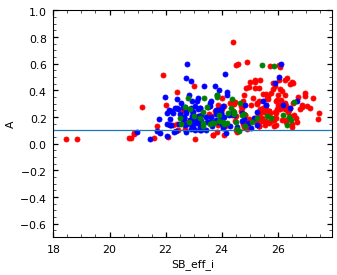

In [22]:
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
#plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('SB_eff_i')
plt.ylabel('A')

Text(0, 0.5, 'A_max')

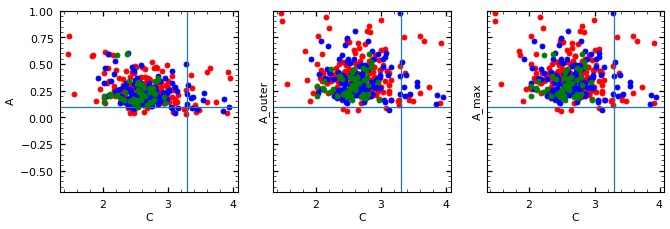

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

plt.sca(axes[0])
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A')

plt.sca(axes[1])
plt.scatter(meas_cat['C'][candy], meas_cat['A_outer'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A_outer'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A_outer'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_outer')

plt.sca(axes[2])
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)
plt.scatter(meas_cat['C'][candy], A_max[candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], A_max[junk], color='r')
plt.scatter(meas_cat['C'][gal], A_max[gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_max')

Text(0, 0.5, 'r50')

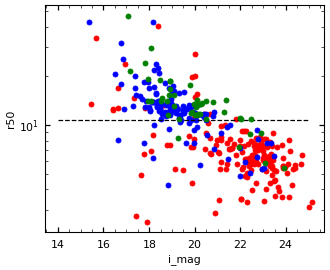

In [24]:
plt.scatter(i_mag[candy], meas_cat['r50'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['r50'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['r50'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

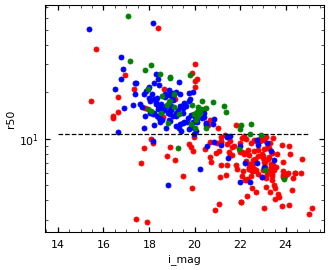

In [25]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(-0.6, 2.5)

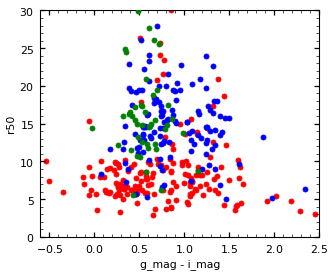

In [26]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)
plt.xlim(-0.6, 2.5)

(0.0, 30.0)

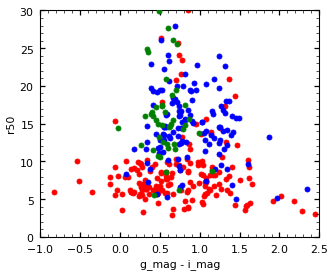

In [27]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')
plt.xlim(-1, 2.5)
plt.ylim(0, 30)

In [28]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 48
Gal: 135
Junk: 190


In [44]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)# & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

# mask &= (meas_cat['SB_0'][:, 2] > 21)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes

mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 34
Gal: 41
Junk: 2


In [ ]:
34 + 41 + 2

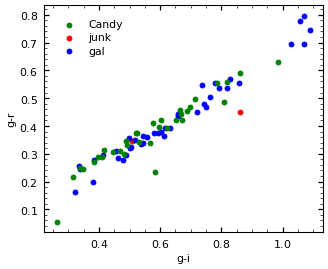

In [30]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

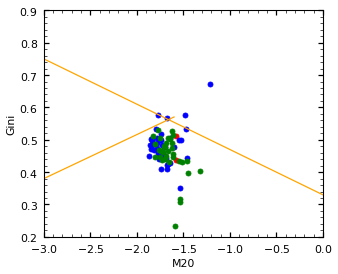

In [31]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

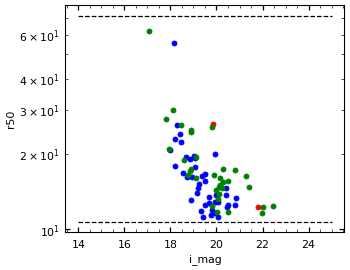

In [32]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.hlines(12 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

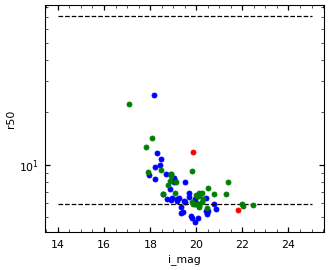

In [33]:
plt.scatter(i_mag[candy & mask], meas_cat['r20'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['r20'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['r20'][gal & mask], color='b')

#plt.ylim(0, 1)
plt.hlines(1 / 0.168, 14, 25, color='k', ls='--')
plt.hlines(12 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

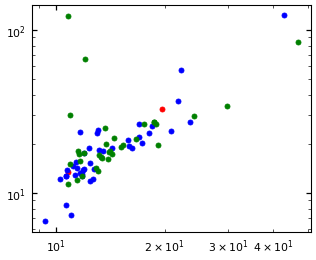

In [34]:
plt.scatter(meas_cat['r50'][candy & mask], meas_cat['sersic_rhalf'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['r50'][junk & mask], meas_cat['sersic_rhalf'][junk & mask], color='r',)
plt.scatter(meas_cat['r50'][gal & mask], meas_cat['sersic_rhalf'][gal & mask], color='b')
plt.xscale('log')
plt.yscale('log')

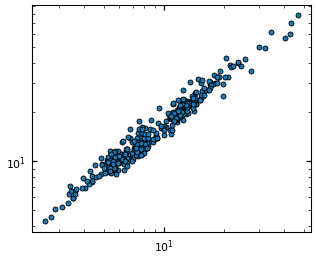

In [35]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50')

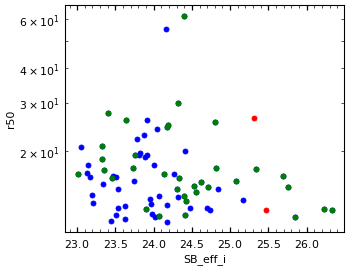

In [36]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

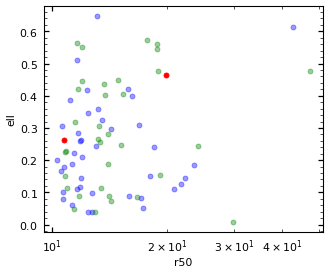

In [37]:
plt.scatter(meas_cat['rhalf_circ'][candy & mask], meas_cat['ell_sym'][candy & mask], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk & mask], meas_cat['ell_sym'][junk & mask], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal & mask], meas_cat['ell_sym'][gal & mask], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r50')
plt.ylabel('ell')
plt.xscale('log')
#plt.yscale('log')

### Save catalog

In [39]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits', overwrite=True)

In [40]:
cuts_cat = Table.read('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits')